# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import utm
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
import prepostprocessing.cleaning as cleaning
import prepostprocessing.pre_processing as preproc
from plots import plots as plots
from qapf import qapf

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

## Mineralogy

In [4]:
mineralogy = pd.read_excel("../_CLEANED/Vistelius_data_cleaned_all.xlsx", index_col=0)

### Check for wrong entries

In [5]:
np.isclose(mineralogy.loc[:, :"oth"].sum(axis=1), mineralogy.loc[:, "sum"])

array([ True,  True,  True, ...,  True,  True,  True])

In [6]:
mineralogy

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,80.80,0.04,10.16,0.61,1.72,NaN,0.40,0.55,2.00,3.59,NaN,0.35,NaN,100.22,NaN
2,80.00,0.10,10.10,0.17,0.56,0.02,0.40,0.35,2.30,5.10,0.05,0.50,NaN,99.65,NaN
3,79.92,0.05,9.89,0.16,1.73,0.02,0.12,0.14,0.75,6.15,NaN,1.02,0.08,100.03,0.30
4,79.65,0.04,9.64,1.15,0.75,0.10,0.45,0.67,3.71,4.25,NaN,0.26,NaN,100.67,0.01
5,79.18,0.08,10.24,0.64,2.60,0.04,0.05,1.25,1.52,3.08,0.01,1.75,0.16,100.60,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,51.09,0.39,19.44,4.09,4.97,0.22,3.79,8.02,4.12,2.01,0.59,1.48,NaN,100.21,0.30
4656,50.90,1.00,17.76,2.61,8.99,0.10,5.07,8.46,2.66,1.64,0.26,0.80,NaN,100.25,NaN
4657,50.40,1.15,18.03,4.21,5.22,0.16,5.84,8.45,2.68,2.24,0.47,1.49,0.03,100.37,0.47
4658,50.34,1.13,22.01,2.28,4.18,0.10,2.73,9.41,4.06,1.09,0.46,2.60,NaN,100.39,0.47


In [7]:
wrong_sum = mineralogy.loc[~np.isclose(mineralogy.loc[:, :"oth"].sum(axis=1), mineralogy.loc[:, "sum"]), :]

In [8]:
# Check to see if any remaining incorrect lines are present
wrong_sum

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs


In [9]:
mineralogy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659 entries, 1 to 4659
Data columns (total 15 columns):
SiO2     4659 non-null float64
TiO2     4626 non-null float64
Al2O3    4659 non-null float64
Fe2O3    4657 non-null float64
FeO      4659 non-null float64
MnO      4544 non-null float64
MgO      4658 non-null float64
CaO      4659 non-null float64
Na2O     4659 non-null float64
K2O      4659 non-null float64
P2O5     3834 non-null float64
l.i.     4659 non-null float64
oth      874 non-null float64
sum      4659 non-null float64
hs       2240 non-null float64
dtypes: float64(15)
memory usage: 582.4 KB


In [10]:
mineralogy.describe()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
count,4659.000000,4626.000000,4659.000000,4657.000000,4659.000000,4544.000000,4658.000000,4659.000000,4659.000000,4659.000000,3834.000000,4659.000000,874.000000,4659.000000,2240.000000
mean,69.929751,0.370305,14.604452,1.087153,2.266705,0.070684,1.074916,2.163700,3.644793,3.962872,0.132280,0.660743,0.193696,99.976201,0.224504
std,5.106250,0.256801,1.632708,0.844197,1.352659,0.111809,1.018722,1.680387,0.757275,1.094288,0.117734,0.444149,0.275826,0.368658,0.260790
min,50.190000,0.010000,9.150000,0.010000,0.070000,0.010000,0.010000,0.020000,0.650000,0.050000,0.010000,0.010000,0.010000,98.840000,0.010000
25%,66.755000,0.180000,13.420000,0.500000,1.290000,0.040000,0.340000,0.840000,3.160000,3.330000,0.060000,0.350000,0.040000,99.690000,0.100000
50%,70.900000,0.310000,14.520000,0.890000,1.990000,0.050000,0.720000,1.700000,3.600000,4.100000,0.110000,0.560000,0.100000,99.950000,0.160000
75%,73.960000,0.500000,15.690000,1.450000,2.995000,0.080000,1.520000,3.130000,4.130000,4.705000,0.170000,0.870000,0.230000,100.260000,0.270000
max,80.800000,2.600000,22.370000,8.410000,9.670000,3.400000,8.420000,11.330000,8.180000,8.300000,1.830000,7.040000,2.820000,101.000000,5.000000


In [11]:
# Addinng P2O5 and oth together doesn't help that much with regard to getting rid of zero/NaN values
(mineralogy["P2O5"] + mineralogy["oth"]).isnull().sum()

3902

In [12]:
wrong_sum.loc[:, :"oth"].sum(axis=1)

Series([], dtype: float64)

In [13]:
mineralogy.head()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,80.80,0.04,10.16,0.61,1.72,NaN,0.40,0.55,2.00,3.59,NaN,0.35,NaN,100.22,NaN
2,80.00,0.10,10.10,0.17,0.56,0.02,0.40,0.35,2.30,5.10,0.05,0.50,NaN,99.65,NaN
3,79.92,0.05,9.89,0.16,1.73,0.02,0.12,0.14,0.75,6.15,NaN,1.02,0.08,100.03,0.30
4,79.65,0.04,9.64,1.15,0.75,0.10,0.45,0.67,3.71,4.25,NaN,0.26,NaN,100.67,0.01
5,79.18,0.08,10.24,0.64,2.60,0.04,0.05,1.25,1.52,3.08,0.01,1.75,0.16,100.60,0.28


### Cleaning



In [14]:
# Replace zero values
mineralogy = preproc.replace_zero(mineralogy, 0.01)

In [15]:
# Also replace NaN values by 0.01
mineralogy = preproc.replace_nan(mineralogy, 0.01)

In [16]:
# Normalize specific columns
mineralogy.loc[:, :"oth"] = preproc.normalize(mineralogy.loc[:, :"oth"])# , total=mineralogy['sum'])

In [17]:
# Renew 'sum' column to reflect changes applied during cleaning
mineralogy["sum"] = mineralogy.loc[:, :"oth"].sum(axis=1)

In [18]:
# Check that sum of all variables + 'sum' == 200
assert all(np.isclose(mineralogy.loc[:, :'sum'].sum(axis=1), 200.0))

In [19]:
mineralogy

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,80.598504,0.039900,10.134663,0.608479,1.715711,0.009975,0.399002,0.548628,1.995012,3.581047,0.009975,0.349127,0.009975,100.0,0.01
2,80.272928,0.100341,10.134457,0.170580,0.561910,0.020068,0.401365,0.351194,2.307847,5.117399,0.050171,0.501706,0.010034,100.0,0.01
3,79.888045,0.049980,9.886046,0.159936,1.729308,0.019992,0.119952,0.139944,0.749700,6.147541,0.009996,1.019592,0.079968,100.0,0.30
4,79.104181,0.039726,9.573940,1.142119,0.744860,0.099315,0.446916,0.665409,3.684576,4.220876,0.009931,0.258218,0.009931,100.0,0.01
5,78.707753,0.079523,10.178926,0.636183,2.584493,0.039761,0.049702,1.242545,1.510934,3.061630,0.009940,1.739563,0.159046,100.0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,50.977849,0.389144,19.397326,4.081022,4.959090,0.219517,3.781680,8.002395,4.110956,2.005588,0.588705,1.476751,0.009978,100.0,0.30
4656,50.768003,0.997407,17.713944,2.603232,8.966687,0.099741,5.056852,8.438061,2.653102,1.635747,0.259326,0.797925,0.009974,100.0,0.01
4657,50.214207,1.145761,17.963535,4.194480,5.200757,0.159410,5.818472,8.418850,2.670121,2.231743,0.468267,1.484507,0.029889,100.0,0.47
4658,50.139442,1.125498,21.922311,2.270916,4.163347,0.099602,2.719124,9.372510,4.043825,1.085657,0.458167,2.589641,0.009960,100.0,0.47


### centred log-ratio (clr) transformation

In [20]:
mineralogy_clr = preproc.clr(mineralogy)
mineralogy_clr.head()

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,5.116216,-2.494637,3.042697,0.229942,1.266563,-3.880932,-0.192052,0.126402,1.417386,2.002391,-3.880932,-0.325583,-3.880932,5.331906,-3.878435
2,5.027136,-1.657475,2.957645,-1.126847,0.065291,-3.266913,-0.271181,-0.404712,1.478019,2.274350,-2.350623,-0.048037,-3.960060,5.246874,-3.963466
3,4.900117,-2.476641,2.810616,-1.313490,1.067213,-3.392932,-1.601172,-1.447021,0.231409,2.335543,-4.086079,0.538894,-2.006637,5.124661,-0.684482
4,4.911676,-2.684842,2.799955,0.673796,0.246352,-1.768551,-0.264473,0.133557,1.845066,1.980953,-4.071136,-0.813039,-4.071136,5.146081,-4.064260
5,4.525075,-2.372377,2.479653,-0.292936,1.108863,-3.065524,-2.842381,0.376495,0.572062,1.278281,-4.451819,0.712967,-1.679230,4.764504,-1.113632


### Principal Component Analysis (PCA)

In [21]:
mineralogy_pca = preproc.pca(mineralogy_clr)
preproc.pca_variance(mineralogy_pca)

9 PCA components  out of 15 components with variance sum 0.966625886419962 needed for obtaining sum of variance > 0.95


array([2.72769107e-01, 1.98486337e-01, 1.35269270e-01, 1.11034812e-01,
       8.48676592e-02, 5.96963124e-02, 4.62857519e-02, 3.20709944e-02,
       2.61456423e-02, 1.88742451e-02, 1.07280680e-02, 3.03849513e-03,
       7.04237437e-04, 2.90679570e-05, 1.71494552e-32])

In [22]:
mineralogy_pca_df = preproc.create_pca_df(mineralogy_pca, mineralogy_clr)

In [23]:
mineralogy_pca_df

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13,PC14,PC15
1,0.070870,-1.570739,-0.662051,0.609276,0.342458,-0.268580,-1.071697,0.923562,0.139705,-1.049387,-0.157287,0.386721,0.210287,0.012389,4.991755e-16
2,-0.261688,-1.375756,0.805870,-0.300059,0.759149,-0.675690,-0.451482,0.306834,0.781251,0.542305,-0.157483,0.341606,0.209525,0.039844,2.172231e-16
3,3.914195,-1.572119,0.813464,1.076293,0.784873,-1.234797,0.391221,-0.305773,0.900094,-1.047324,-0.883750,0.863245,0.139512,0.048587,5.252676e-16
4,-0.160643,-1.815379,-1.297618,0.321477,-0.189479,0.327796,0.756335,1.567153,0.233893,0.037679,-0.114667,-0.074479,0.277424,0.028466,-1.286639e-16
5,3.508039,-1.311824,0.204961,1.717288,-0.080573,-1.328450,1.018126,-0.541024,-1.417501,-1.140806,-0.429481,0.342445,0.272092,0.014137,7.446751e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,-0.006406,2.916627,-0.195252,-1.112546,-1.041502,-0.522344,0.727264,0.878206,-0.288274,-0.425628,0.025780,-0.221353,-0.205672,0.066938,-1.660513e-16
4656,-2.943692,2.152769,-0.382931,0.289568,-0.498874,0.052471,-0.014788,0.022861,-0.220074,-0.690008,0.068836,0.207449,-0.131385,0.085468,4.239758e-16
4657,0.390174,3.309386,0.031281,-0.029892,-1.308320,-0.381930,0.393931,0.030935,0.068661,-0.155013,-0.229203,0.029254,-0.115538,0.087171,1.345464e-16
4658,0.424394,3.407414,-0.188329,-0.859408,-0.620405,-1.057895,0.184711,-0.269273,-0.595109,-0.036959,0.622897,-0.002238,-0.274277,0.062982,4.152935e-16


____

## Coordinates

In [24]:
coordinates = pd.read_excel("../_DATA/full_with_coordinates.xlsx", index_col=0, usecols=[0, 1, 2, 3])

In [25]:
coordinates

,Latitude,Longitude,past_mer
1,"44°31'30.0""","138°37'30.0""",NaN
2,"54°12'10.0""","119°24'0.0""",NaN
3,"62°36'0.0""","155°36'0.0""",NaN
4,"61°35'0.0""","146°2'0.0""",NaN
5,"68°55'0.0""","164°24'0.0""",NaN
...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN
4656,"46°56'30.0""","137°5'3.0""",NaN
4657,"58°12'0.0""","138°12'0.0""",NaN
4658,"60°51'0.0""","147°31'0.0""",NaN


In [26]:
# Delete negative signs in "Longitude" column for dms2dec function to work properly
coordinates["Longitude"] = coordinates["Longitude"].str.replace("-", "")

In [27]:
# Include W in "Longitude" column
sum_ = 0

for index, row in coordinates.iterrows():
    if ("W" in str(row["past_mer"])) or ("w" in str(row["past_mer"])):
        coordinates.loc[index, "Longitude"] = row["Longitude"] + "W"
        
        sum_ += 1

In [28]:
# Check that all occurences of "W" or "w" are catched
assert sum_ == int(coordinates["past_mer"].value_counts())

### Convert from degrees to decimal format

In [29]:
coordinates["Y"] = coordinates.loc[:, "Latitude"].apply(cleaning.dms2dec)
coordinates["X"] = coordinates.loc[:, "Longitude"].apply(cleaning.dms2dec)

In [30]:
# Check
coordinates.loc[42, "X"]

149.38333333333333

In [31]:
coordinates

,Latitude,Longitude,past_mer,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525000,138.625000
2,"54°12'10.0""","119°24'0.0""",NaN,54.202778,119.400000
3,"62°36'0.0""","155°36'0.0""",NaN,62.600000,155.600000
4,"61°35'0.0""","146°2'0.0""",NaN,61.583333,146.033333
5,"68°55'0.0""","164°24'0.0""",NaN,68.916667,164.400000
...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.700000,164.383333
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941667,137.084167
4657,"58°12'0.0""","138°12'0.0""",NaN,58.200000,138.200000
4658,"60°51'0.0""","147°31'0.0""",NaN,60.850000,147.516667


### adding noise to coordinates

In [32]:
coordinates_noise = pd.read_excel("../_INTERPOLATION/coordinates_decimal.xlsx", index_col=0)

In [33]:
coordinates_noise = coordinates_noise.rename({"Y": "Y_without_noise", "X": "X_without_noise"}, axis=1)

In [34]:
# coordinates_noise["random_value"] = np.random.random(size=len(coordinates_noise))
# coordinates_noise["mean"] = 0
# coordinates_noise["std"] = 0.00007

# You don't seem to use the 'random_value' anywhere so commented it
# Instead of assigning the mean and std to every row it is much faster to define it once
# and then use it when calling the random normal sample.
noise_mean = 0
noise_std = 0.00007

In [35]:
# You can set up your own 'pseudo' random number generator with np.random.RandomState(x)
# where x is the random seed that you can choose, I just chose 4343
# This way the samples from the normal distribution will be random but will be the same every time you
# rerun this cell, so that your results in the second notebook 'Interpolation' will also stay the same
# even after rerunning. Otherwise, at every run of the next cell, numpy will choose a new random seed.
# You may also find online that people say to just set the RandomState with np.random.seed = 4343
# but this will affect every random process you start anywhere and that's not what you want for now
pnrg = np.random.RandomState(4343)

In [36]:
# coordinates_noise["normal_distribution"] =  np.random.normal(noise_mean, noise_std)

# Would sample two random numbers so that the coordinates can change in all direction and not just NE or SW
coordinates_noise["noise_for_X"] =  pnrg.normal(noise_mean, noise_std, size=coordinates_noise.shape[0])
coordinates_noise["noise_for_Y"] =  pnrg.normal(noise_mean, noise_std, size=coordinates_noise.shape[0])

In [37]:
coordinates_noise["Y"] = coordinates_noise["Y_without_noise"] + coordinates_noise["noise_for_X"]
coordinates_noise["X"] = coordinates_noise["X_without_noise"] + coordinates_noise["noise_for_Y"]

In [38]:
# NEW
coordinates_noise

,Latitude,Longitude,past_mer,Y_without_noise,X_without_noise,noise_for_X,noise_for_Y,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525027,138.625027,0.000058,-0.000078,44.525085,138.624949
2,"54°12'10.0""","119°24'0.0""",NaN,54.202861,119.400083,0.000016,-0.000237,54.202877,119.399847
3,"62°36'0.0""","155°36'0.0""",NaN,62.600001,155.600001,0.000044,-0.000109,62.600044,155.599891
4,"61°35'0.0""","146°2'0.0""",NaN,61.583302,146.033302,0.000132,-0.000076,61.583433,146.033226
5,"68°55'0.0""","164°24'0.0""",NaN,68.916552,164.399886,-0.000019,-0.000077,68.916533,164.399808
...,...,...,...,...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699978,164.383312,-0.000118,0.000014,66.699861,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941677,137.084177,-0.000016,-0.000020,46.941661,137.084157
4657,"58°12'0.0""","138°12'0.0""",NaN,58.199973,138.199973,-0.000079,-0.000040,58.199894,138.199934
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849992,147.516659,-0.000163,0.000135,60.849829,147.516794


In [39]:
# OLD
coordinates_noise

,Latitude,Longitude,past_mer,Y_without_noise,X_without_noise,noise_for_X,noise_for_Y,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525027,138.625027,0.000058,-0.000078,44.525085,138.624949
2,"54°12'10.0""","119°24'0.0""",NaN,54.202861,119.400083,0.000016,-0.000237,54.202877,119.399847
3,"62°36'0.0""","155°36'0.0""",NaN,62.600001,155.600001,0.000044,-0.000109,62.600044,155.599891
4,"61°35'0.0""","146°2'0.0""",NaN,61.583302,146.033302,0.000132,-0.000076,61.583433,146.033226
5,"68°55'0.0""","164°24'0.0""",NaN,68.916552,164.399886,-0.000019,-0.000077,68.916533,164.399808
...,...,...,...,...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699978,164.383312,-0.000118,0.000014,66.699861,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941677,137.084177,-0.000016,-0.000020,46.941661,137.084157
4657,"58°12'0.0""","138°12'0.0""",NaN,58.199973,138.199973,-0.000079,-0.000040,58.199894,138.199934
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849992,147.516659,-0.000163,0.000135,60.849829,147.516794


In [40]:
coordinates_noise.to_excel("../_DATA/full_with_coordinates_noice_final_new.xlsx")

In [41]:
coordinates = pd.read_excel("../_DATA/full_with_coordinates_noice_final.xlsx", index_col=0, usecols=[0, 1, 2, 3, 10, 11])

In [42]:
coordinates

,Latitude,Longitude,past_mer,Y,X
1,"44°31'30.0""","138°37'30.0""",NaN,44.525040,138.625040
2,"54°12'10.0""","119°24'0.0""",NaN,54.202798,119.400020
3,"62°36'0.0""","155°36'0.0""",NaN,62.599978,155.599978
4,"61°35'0.0""","146°2'0.0""",NaN,61.583249,146.033249
5,"68°55'0.0""","164°24'0.0""",NaN,68.916572,164.399905
...,...,...,...,...,...
4655,"66°42'0.0""","164°23'0.0""",NaN,66.699992,164.383326
4656,"46°56'30.0""","137°5'3.0""",NaN,46.941584,137.084084
4657,"58°12'0.0""","138°12'0.0""",NaN,58.200076,138.200076
4658,"60°51'0.0""","147°31'0.0""",NaN,60.849958,147.516625


### Convert to UTM coordinates

In [43]:
coordinates_utm = coordinates.apply(lambda row : utm.from_latlon(row["Y"], row["X"], force_zone_number=48, force_zone_letter="U"), axis=1)
coordinates_utm = coordinates_utm.apply(pd.Series)
coordinates_utm.columns = ["Y_UTM", "X_UTM", "ZoneNumber", "ZoneLetter"]

In [44]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
1,3.166850e+06,5.512837e+06,48,U
2,1.436111e+06,6.102354e+06,48,U
3,2.874853e+06,7.966637e+06,48,U
4,2.565651e+06,7.521202e+06,48,U
5,2.540731e+06,8.757731e+06,48,U
...,...,...,...,...
4655,2.759727e+06,8.616851e+06,48,U
4656,2.927123e+06,5.721711e+06,48,U
4657,2.397980e+06,6.939549e+06,48,U
4658,2.684981e+06,7.505261e+06,48,U


In [45]:
coordinates_utm["ZoneNumber"].value_counts()

48    4659
Name: ZoneNumber, dtype: int64

In [46]:
coordinates_utm["ZoneLetter"].value_counts()

U    4659
Name: ZoneLetter, dtype: int64

In [47]:
(coordinates_utm["ZoneNumber"].astype(str) + coordinates_utm["ZoneLetter"]).value_counts()

48U    4659
dtype: int64

In [48]:
coordinates_utm.to_excel("../_INTERPOLATION/coordinates_UTM.xlsx")

In [49]:
cof= pd.read_excel("../_RESULTS/working_data.xlsx", index_col=0, usecols = lambda column : column not in ["Lat_deg", "Lat_min", "Lat_sec", "Long_deg", "Long_min", "Long_sec", "past_mer"] )

In [50]:
cof

,type_granite,time,massif,sampler,others,sampler+year
512,Granite coarse-grained,Tr-J,Yugalkan massif,T.A.Alfer'eva,NaN,"A.D.Kanischev,1959"
1299,Granite coarse-grained,Tr-J,NaN,G.L.Znamenskaya,NaN,"N.P.Kostyakov,1961"
1536,Bt granite porphyraceous,Tr-J,NaN,E.G.Ivanova,NaN,"L.A.Kozubova,1957"
1760,Bt granite medium-grained,Tr-J,NaN,NaN,NaN,"V.I.Fel'dman,1956"
1890,Plagiogranite,Tr-J,NaN,NI.Serebryakova,NaN,"A.V.Vnukov,1959"
...,...,...,...,...,...,...
1150,Granite leucocratic,J,Upper-Buy massif,NaN,.N.P.Mel'nikova,"V.V.Starchenko,1968"
1396,Granite,Tr,Ust'-Nerchugan massifmassif,N.Aolebedeva,NaN,"K.F.Khatskevich,1967"
2116,Granite,NaN,NaN,N.I.Serebryakov~,NaN,"V.Yu.Shenfil,1962"
2973,Bt granite-porphyry,NaN,Ergelyakh massif,G.P.Ignatovich,NaN,"G.G.Naumov,1978"


### adding metadata for Biplots

In [51]:
CIPW = pd.read_excel("../_CIPW/CIPW/1_normalized_QAPF_plot.xlsx", index_col=0, usecols=[0, 3])

In [52]:
classification_renaming_dict = {"quartz monzodiorite\nquartz monzogabbro" : "quartz monzodiorite\quartz monzogabbro",
                                "quartz diorite\nquartz gabbro\nquartz anorthosite" : "quartz diorite\quartz gabbro\quartz anorthosite"}

In [53]:
CIPW['QAPF'] = CIPW['QAPF'].replace(classification_renaming_dict)

------

In [54]:
mineralogy_zeros = pd.read_excel("../_CLEANED/Vistelius_data_cleaned_all.xlsx", index_col=0)
mineralogy_biplot_zeros = pd.read_excel("../_CLEANED/Vistelius_data_cleaned_all.xlsx", index_col=0, usecols=[0])

In [55]:
mineralogy_zeros = preproc.replace_nan(mineralogy_zeros, 0.001)

In [56]:
mineralogy_zeros.loc[mineralogy_zeros['TiO2'] == 0.001, 'mineral_zero'] = 'mineral'
mineralogy_zeros.loc[mineralogy_zeros['Fe2O3'] == 0.001, 'mineral_zero'] = 'mineral'
mineralogy_zeros.loc[mineralogy_zeros['MnO'] == 0.001, 'mineral_zero'] = 'mineral'
mineralogy_zeros.loc[mineralogy_zeros['P2O5'] == 0.001, 'mineral_zero'] = 'mineral'
mineralogy_zeros.loc[mineralogy_zeros['oth'] == 0.001, 'oth_zero'] = 'oth'

In [57]:
mineralogy_zeros

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs,mineral_zero,oth_zero
1,80.80,0.04,10.16,0.61,1.72,0.001,0.40,0.55,2.00,3.59,0.001,0.35,0.001,100.22,0.001,mineral,oth
2,80.00,0.10,10.10,0.17,0.56,0.020,0.40,0.35,2.30,5.10,0.050,0.50,0.001,99.65,0.001,NaN,oth
3,79.92,0.05,9.89,0.16,1.73,0.020,0.12,0.14,0.75,6.15,0.001,1.02,0.080,100.03,0.300,mineral,NaN
4,79.65,0.04,9.64,1.15,0.75,0.100,0.45,0.67,3.71,4.25,0.001,0.26,0.001,100.67,0.010,mineral,oth
5,79.18,0.08,10.24,0.64,2.60,0.040,0.05,1.25,1.52,3.08,0.010,1.75,0.160,100.60,0.280,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,51.09,0.39,19.44,4.09,4.97,0.220,3.79,8.02,4.12,2.01,0.590,1.48,0.001,100.21,0.300,NaN,oth
4656,50.90,1.00,17.76,2.61,8.99,0.100,5.07,8.46,2.66,1.64,0.260,0.80,0.001,100.25,0.001,NaN,oth
4657,50.40,1.15,18.03,4.21,5.22,0.160,5.84,8.45,2.68,2.24,0.470,1.49,0.030,100.37,0.470,NaN,NaN
4658,50.34,1.13,22.01,2.28,4.18,0.100,2.73,9.41,4.06,1.09,0.460,2.60,0.001,100.39,0.470,NaN,oth


In [58]:
mineralogy_zeros = preproc.replace_nan(mineralogy_zeros, "")

In [59]:
# Values are already 'str' so no need to map them to 'str' anymore
mineralogy_zeros['zero'] = mineralogy_zeros['mineral_zero'] + mineralogy_zeros['oth_zero']

In [60]:
mineralogy_zeros

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs,mineral_zero,oth_zero,zero
1,80.80,0.04,10.16,0.61,1.72,0.001,0.40,0.55,2.00,3.59,0.001,0.35,0.001,100.22,0.001,mineral,oth,mineraloth
2,80.00,0.10,10.10,0.17,0.56,0.020,0.40,0.35,2.30,5.10,0.050,0.50,0.001,99.65,0.001,,oth,oth
3,79.92,0.05,9.89,0.16,1.73,0.020,0.12,0.14,0.75,6.15,0.001,1.02,0.080,100.03,0.300,mineral,,mineral
4,79.65,0.04,9.64,1.15,0.75,0.100,0.45,0.67,3.71,4.25,0.001,0.26,0.001,100.67,0.010,mineral,oth,mineraloth
5,79.18,0.08,10.24,0.64,2.60,0.040,0.05,1.25,1.52,3.08,0.010,1.75,0.160,100.60,0.280,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,51.09,0.39,19.44,4.09,4.97,0.220,3.79,8.02,4.12,2.01,0.590,1.48,0.001,100.21,0.300,,oth,oth
4656,50.90,1.00,17.76,2.61,8.99,0.100,5.07,8.46,2.66,1.64,0.260,0.80,0.001,100.25,0.001,,oth,oth
4657,50.40,1.15,18.03,4.21,5.22,0.160,5.84,8.45,2.68,2.24,0.470,1.49,0.030,100.37,0.470,,,
4658,50.34,1.13,22.01,2.28,4.18,0.100,2.73,9.41,4.06,1.09,0.460,2.60,0.001,100.39,0.470,,oth,oth


In [61]:
mineralogy_biplot_zeros['zero'] = mineralogy_zeros['zero']

In [62]:
mineralogy_biplot_zeros.replace('', 'no_zero', inplace=True)

In [63]:
mineralogy_biplot_zeros

,zero
1,mineraloth
2,oth
3,mineral
4,mineraloth
5,no_zero
...,...
4655,oth
4656,oth
4657,no_zero
4658,oth


------

### new metadata for biplots

In [64]:
mineralogy2 = pd.read_excel("../_CLEANED/Vistelius_data_cleaned_all.xlsx", index_col=0)

In [65]:
mineralogy2 = preproc.replace_nan(mineralogy2, 0)

In [66]:
# This is one way to go
mineralogy2['oth'] = mineralogy2['P2O5'] + mineralogy2['l.i.'] + mineralogy2['oth']
# Another way would be to just remove the original 'oth' column from the dataset 
# as it only has values for ca. 900 samples
# You could leave the P2O5 and l.i. columns unchanged, although P2O5 should be checked as it has around 800 zero/NaN values
# l.i. doesn't contain any zero/NaN values so that variable is perfectly fine to use (on its own)


In [67]:
# You could also drop 'sum' and 'hs' here as you will not use them anyway
mineralogy2.drop(["l.i.", "P2O5"], axis = 1, inplace = True)

In [68]:
mineralogy2 = preproc.replace_zero(mineralogy2, 0.01)

In [69]:
mineralogy2.loc[:, :"oth"] = preproc.normalize(mineralogy2.loc[:, :"oth"])# , total=mineralogy['sum'])

In [70]:
mineralogy2["sum"] = mineralogy2.loc[:, :"oth"].sum(axis=1)

In [71]:
assert all(np.isclose(mineralogy2.loc[:, :'sum'].sum(axis=1), 200.0))

In [72]:
mineralogy

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,P2O5,l.i.,oth,sum,hs
1,80.598504,0.039900,10.134663,0.608479,1.715711,0.009975,0.399002,0.548628,1.995012,3.581047,0.009975,0.349127,0.009975,100.0,0.01
2,80.272928,0.100341,10.134457,0.170580,0.561910,0.020068,0.401365,0.351194,2.307847,5.117399,0.050171,0.501706,0.010034,100.0,0.01
3,79.888045,0.049980,9.886046,0.159936,1.729308,0.019992,0.119952,0.139944,0.749700,6.147541,0.009996,1.019592,0.079968,100.0,0.30
4,79.104181,0.039726,9.573940,1.142119,0.744860,0.099315,0.446916,0.665409,3.684576,4.220876,0.009931,0.258218,0.009931,100.0,0.01
5,78.707753,0.079523,10.178926,0.636183,2.584493,0.039761,0.049702,1.242545,1.510934,3.061630,0.009940,1.739563,0.159046,100.0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,50.977849,0.389144,19.397326,4.081022,4.959090,0.219517,3.781680,8.002395,4.110956,2.005588,0.588705,1.476751,0.009978,100.0,0.30
4656,50.768003,0.997407,17.713944,2.603232,8.966687,0.099741,5.056852,8.438061,2.653102,1.635747,0.259326,0.797925,0.009974,100.0,0.01
4657,50.214207,1.145761,17.963535,4.194480,5.200757,0.159410,5.818472,8.418850,2.670121,2.231743,0.468267,1.484507,0.029889,100.0,0.47
4658,50.139442,1.125498,21.922311,2.270916,4.163347,0.099602,2.719124,9.372510,4.043825,1.085657,0.458167,2.589641,0.009960,100.0,0.47


**remark**
-when renaming the oth column i got an assertion error, but seems to work when the common column's name is oth  
**An assertion error from pandas or from the in-house code? But you resolved it, so ok** --> not quite sure, but had something to do with the name of the column, so i guess something to do with the in-house code, but i works, so its fine

In [73]:
coordinates_full2 = pd.concat([coordinates_utm, coordinates, mineralogy, cof, CIPW, mineralogy_biplot_zeros], axis = 1)

In [74]:
coordinates_full2

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter,Latitude,Longitude,past_mer,Y,X,SiO2,...,sum,hs,type_granite,time,massif,sampler,others,sampler+year,QAPF,zero
1,3.166850e+06,5.512837e+06,48,U,"44°31'30.0""","138°37'30.0""",NaN,44.525040,138.625040,80.598504,...,100.0,0.01,Granite leucogranitic,K,NaN,NaN,NaN,"V.N.Musin,1970",monzo granite,mineraloth
2,1.436111e+06,6.102354e+06,48,U,"54°12'10.0""","119°24'0.0""",NaN,54.202798,119.400020,80.272928,...,100.0,0.01,Granite leucocratic,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969",monzo granite,oth
3,2.874853e+06,7.966637e+06,48,U,"62°36'0.0""","155°36'0.0""",NaN,62.599978,155.599978,79.888045,...,100.0,0.30,Granite leucocratic coarse-grained,K,Omsukchan massif,P.M.Bosek,NaN,"O.S.Gracheva,1948",syeno granite,mineral
4,2.565651e+06,7.521202e+06,48,U,"61°35'0.0""","146°2'0.0""",NaN,61.583249,146.033249,79.104181,...,100.0,0.01,Granite leucocratic,K,Buksandzhin massif,A.Kh.Brovtman,NaN,"A.F.Mikhaylov,1948",monzo granite,mineraloth
5,2.540731e+06,8.757731e+06,48,U,"68°55'0.0""","164°24'0.0""",NaN,68.916572,164.399905,78.707753,...,100.0,0.28,Granite-porphyry micropegmatitic,K,Attykveem massif,L.G.Semenova,0th.:S-0.16,"A.I.Sadovsky,1963",monzo granite,no_zero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4655,2.759727e+06,8.616851e+06,48,U,"66°42'0.0""","164°23'0.0""",NaN,66.699992,164.383326,50.977849,...,100.0,0.30,Diorite,K,Egdegkych massif,NaN,Oth.:co2-0.12,"V.A.lgnat'ev,1964",monzodiorite monzogabbro,oth
4656,2.927123e+06,5.721711e+06,48,U,"46°56'30.0""","137°5'3.0""",NaN,46.941584,137.084084,50.768003,...,100.0,0.01,Quartz diorite,K,Verkhneplotnikovsky massif,NaN,NaN,"A.A.Syas'ko,1969",monzodiorite monzogabbro,oth
4657,2.397980e+06,6.939549e+06,48,U,"58°12'0.0""","138°12'0.0""",NaN,58.200076,138.200076,50.214207,...,100.0,0.47,Diorite,J,NaN,NaN,"Oth.:co2-0.02,so3-0.0l","N.N.Remizov,1967",monzodiorite monzogabbro,no_zero
4658,2.684981e+06,7.505261e+06,48,U,"60°51'0.0""","147°31'0.0""",NaN,60.849958,147.516625,50.139442,...,100.0,0.47,Diorite,K,NaN,NaN,NaN,"A.P.Osipov,1966",monzodiorite monzogabbro,oth


In [75]:
coordinates_full2.to_excel("../_BIPLOTS/coordinates_full_data.xlsx")


### Grouping of the data

In [76]:
areax = coordinates_full2
areax["area"] = ""

In [77]:
areay1 = areax[areax["X"].between(107.20, 121)]
area1 = areay1[areay1["Y"].between(48.85, 56.6)]
area1["area"] = 1
area1.to_excel("../_BIPLOTS/area1.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
areay2 = areax[areax["X"].between(131.75, 141.5)]
area2 = areay2[areay2["Y"].between(42, 56)]
area2["area"] = 2
area2.to_excel("../_BIPLOTS/area2.xlsx")


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
areay3 = areax[areax["X"].between(133, 160.5)]
area3 = areay3[areay3["Y"].between(58.6, 70.85)]
area3["area"] = 3
area3.to_excel("../_BIPLOTS/area3.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
areay4 = areax[areax["X"].between(160.5, 180)]
area4 = areay4[areay4["Y"].between(60.75, 70.25)]
area4["area"] = 4
area4.to_excel("../_BIPLOTS/area4.xlsx")

C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
areay5 = areax[areax["X"].between(-180, -165)]
area5 = areay5[areay5["Y"].between(63, 70)]
area5["area"] = 5
area5.to_excel("../_BIPLOTS/area5.xlsx")

In [82]:
area12 = area1.append(area2)
area123 = area12.append(area3) 
area1234 = area123.append(area4) 
area = area1234.append(area5) 
area.to_excel("../_BIPLOTS/area_subdivided.xlsx")

____

## Metadata

In [83]:
metadata = pd.read_excel("../_BIPLOTS/coordinates_full_data.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])

In [84]:
metadata

,type_granite,time,massif,sampler,others,sampler+year,QAPF,zero
1,Granite leucogranitic,K,NaN,NaN,NaN,"V.N.Musin,1970",monzo granite,mineraloth
2,Granite leucocratic,Tr,NaN,V.I.Zhigalova,NaN,"E.A.Ivanov,1969",monzo granite,oth
3,Granite leucocratic coarse-grained,K,Omsukchan massif,P.M.Bosek,NaN,"O.S.Gracheva,1948",syeno granite,mineral
4,Granite leucocratic,K,Buksandzhin massif,A.Kh.Brovtman,NaN,"A.F.Mikhaylov,1948",monzo granite,mineraloth
5,Granite-porphyry micropegmatitic,K,Attykveem massif,L.G.Semenova,0th.:S-0.16,"A.I.Sadovsky,1963",monzo granite,no_zero
...,...,...,...,...,...,...,...,...
4655,Diorite,K,Egdegkych massif,NaN,Oth.:co2-0.12,"V.A.lgnat'ev,1964",monzodiorite monzogabbro,oth
4656,Quartz diorite,K,Verkhneplotnikovsky massif,NaN,NaN,"A.A.Syas'ko,1969",monzodiorite monzogabbro,oth
4657,Diorite,J,NaN,NaN,"Oth.:co2-0.02,so3-0.0l","N.N.Remizov,1967",monzodiorite monzogabbro,no_zero
4658,Diorite,K,NaN,NaN,NaN,"A.P.Osipov,1966",monzodiorite monzogabbro,oth


In [85]:
metadata["type_granite"].value_counts()

Granite                            656
Granodiorite                       523
Granite-porphyry                   282
Bt granite                         268
Granite leucocratic                220
                                  ... 
Granite porphyry alkaline            1
Bt microgranite                      1
Granite granophyric subalkaline      1
Monzosyenite                         1
Granite alkaline(leucogranite)       1
Name: type_granite, Length: 401, dtype: int64

In [86]:
metadata["massif"].value_counts()

Ulakhan-Sis massif         58
Khoboyotuu-Echiy massif    56
Vladimirsky massif         35
Zimov'e massif             33
Bom-Gorkhon massif         31
                           ..
Kalalagin massif            1
Elazavs massif              1
Neorchan Nukh massif        1
Lyuneveem massif            1
Upper-Omuk massif           1
Name: massif, Length: 941, dtype: int64

In [87]:
metadata["time"].value_counts()

K       2522
J        825
Tr       517
Pg       365
Tr-J     338
Mz        88
Name: time, dtype: int64

In [88]:
metadata["sampler"].value_counts()

L.S.Voronova       120
D.M.Shuster         87
N.A.Lebedeva        86
V.I.Zhigalova       70
N.P.Mel'nikova      51
                  ... 
L.VSergeeva          1
L.G.Potepalova       1
I~M.Lalykina         1
E.B.Galayskaya       1
S.Ya.Gershenzon      1
Name: sampler, Length: 736, dtype: int64

In [89]:
metadata["sampler+year"].value_counts()

G.A.Valuy,1975           76
V.A.Popeko,1968          61
V.A.Faradzhev,1971       43
R.O.Galabala,1976        37
V.S.Ivanov,1968          37
                         ..
E.M.Shesterenkin,1965     1
M.D.Elianov,1953          1
M.I.Rokhlin,1936          1
A.F.Baranov,1950          1
A.T.Terteryan,1973        1
Name: sampler+year, Length: 1392, dtype: int64

In [90]:
metadata["QAPF"].value_counts()

monzo granite                                      3256
granodiorite                                        678
quartz monzodiorite\quartz monzogabbro              356
quartz monzonite                                    270
syeno granite                                        35
monzodiorite monzogabbro                             33
tonalite                                             12
monzonite                                             9
quartz diorite\quartz gabbro\quartz anorthosite       4
quartz-rich granitoid                                 4
quartz syenite                                        1
diorite gabbro anorthosite                            1
Name: QAPF, dtype: int64

In [91]:
metadata["zero"].value_counts()

oth           3020
mineraloth     765
no_zero        736
mineral        138
Name: zero, dtype: int64

## data for each area

In [92]:
metadata_area1 = pd.read_excel("../_BIPLOTS/area1.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])
metadata_area2 = pd.read_excel("../_BIPLOTS/area2.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])
metadata_area3 = pd.read_excel("../_BIPLOTS/area3.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])
metadata_area4 = pd.read_excel("../_BIPLOTS/area4.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])
metadata_area5 = pd.read_excel("../_BIPLOTS/area5.xlsx", index_col=0, usecols=[0, 25, 26, 27, 28, 29, 30, 31, 32])


In [93]:
coordinates_utm_area1 = pd.read_excel("../_BIPLOTS/area1.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area2 = pd.read_excel("../_BIPLOTS/area2.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area3 = pd.read_excel("../_BIPLOTS/area3.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area4 = pd.read_excel("../_BIPLOTS/area4.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])
coordinates_utm_area5 = pd.read_excel("../_BIPLOTS/area5.xlsx", index_col=0, usecols=[0, 1, 2, 3, 4])

In [94]:
coordinates_area1 = pd.read_excel("../_BIPLOTS/area1.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area2 = pd.read_excel("../_BIPLOTS/area2.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area3 = pd.read_excel("../_BIPLOTS/area3.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area4 = pd.read_excel("../_BIPLOTS/area4.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])
coordinates_area5 = pd.read_excel("../_BIPLOTS/area5.xlsx", index_col=0, usecols=[0, 5, 6, 7, 8, 9])

In [95]:
mineralogy_area1 = pd.read_excel("../_BIPLOTS/area1.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
mineralogy_area2 = pd.read_excel("../_BIPLOTS/area2.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
mineralogy_area3 = pd.read_excel("../_BIPLOTS/area3.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
mineralogy_area4 = pd.read_excel("../_BIPLOTS/area4.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
mineralogy_area5 = pd.read_excel("../_BIPLOTS/area5.xlsx", index_col=0, usecols=[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [96]:
mineralogy_clr_area1 = preproc.clr(mineralogy_area1)
mineralogy_clr_area2 = preproc.clr(mineralogy_area2)
mineralogy_clr_area3 = preproc.clr(mineralogy_area3)
mineralogy_clr_area4 = preproc.clr(mineralogy_area4)
mineralogy_clr_area5 = preproc.clr(mineralogy_area5)

In [97]:
mineralogy_pca_area1 = preproc.pca(mineralogy_clr_area1)
preproc.pca_variance(mineralogy_pca_area1)

mineralogy_pca_area2 = preproc.pca(mineralogy_clr_area2)
preproc.pca_variance(mineralogy_pca_area2)

mineralogy_pca_area3 = preproc.pca(mineralogy_clr_area3)
preproc.pca_variance(mineralogy_pca_area3)

mineralogy_pca_area4 = preproc.pca(mineralogy_clr_area4)
preproc.pca_variance(mineralogy_pca_area4)

mineralogy_pca_area5 = preproc.pca(mineralogy_clr_area5)
preproc.pca_variance(mineralogy_pca_area5)

8 PCA components  out of 14 components with variance sum 0.9553984928282261 needed for obtaining sum of variance > 0.95
8 PCA components  out of 14 components with variance sum 0.9591982816727399 needed for obtaining sum of variance > 0.95
8 PCA components  out of 14 components with variance sum 0.9625993206861311 needed for obtaining sum of variance > 0.95
8 PCA components  out of 14 components with variance sum 0.9600586492137326 needed for obtaining sum of variance > 0.95
7 PCA components  out of 14 components with variance sum 0.9603755687154656 needed for obtaining sum of variance > 0.95


array([3.22282348e-01, 2.19857091e-01, 1.56418704e-01, 1.01366047e-01,
       7.58309221e-02, 5.28011825e-02, 3.18192736e-02, 1.72338731e-02,
       1.29469049e-02, 7.43576571e-03, 1.41724489e-03, 5.62594207e-04,
       2.80485066e-05, 1.61803272e-32])

In [98]:
mineralogy_pca_area1_df = preproc.create_pca_df(mineralogy_pca_area1, mineralogy_clr_area1)
mineralogy_pca_area2_df = preproc.create_pca_df(mineralogy_pca_area2, mineralogy_clr_area2)
mineralogy_pca_area3_df = preproc.create_pca_df(mineralogy_pca_area3, mineralogy_clr_area3)
mineralogy_pca_area4_df = preproc.create_pca_df(mineralogy_pca_area4, mineralogy_clr_area4)
mineralogy_pca_area5_df = preproc.create_pca_df(mineralogy_pca_area5, mineralogy_clr_area5)

In [99]:
mineralogy_all_areas = {
    "area1": mineralogy_area1,
    "area2": mineralogy_area2,
    "area3": mineralogy_area3,
    "area4": mineralogy_area4,
    "area5": mineralogy_area5,
}

In [100]:
mineralogy_pca_all_areas = {
    "area1": mineralogy_pca_area1,
    "area2": mineralogy_pca_area2,
    "area3": mineralogy_pca_area3,
    "area4": mineralogy_pca_area4,
    "area5": mineralogy_pca_area5,
}

In [101]:
mineralogy_pca_df_all_areas = {
    "area1": mineralogy_pca_area1_df,
    "area2": mineralogy_pca_area2_df,
    "area3": mineralogy_pca_area3_df,
    "area4": mineralogy_pca_area4_df,
    "area5": mineralogy_pca_area5_df,
}

In [102]:
metadata_all_areas = {
    "area1": metadata_area1,
    "area2": metadata_area2,
    "area3": metadata_area3,
    "area4": metadata_area4,
    "area5": metadata_area5,
}

## CPV plots

**You can now also quickly query the number of PCs needed for reaching a different threshold value than 0.95. See example below.**

**remark**
1) I made an excel file called "error budget" to see the number of PC's needed. Did it first for the MSPE, but also for the Var(OK) from the excel file you send during the meeting. It seems tha we have to use the variance instead of the gain in MSPE. But the variances do differ greatly with the ones below. what is the difference between both variances? (the one used here and the ones in the error budget)  
**The variances used here are related to the PCA model and sum up to one (because they represent ratios; 'explained_variance_ratio_' method of PCA class of scitkit-learn).   
The VAR(OK) is the variance of the interpolated data (of the grid) and can thus be seen as how much variance is captured by the interpolation itself. 
The MSPE (Mean Squared Prediction Error) is a result from the cross validation that was performed and is thus a direct measure of how well the interpolation performed. That's why we use this measure in the error budget to further determine how many PCs are useful to use in the actual interpolation. In other words, which model (with certain number of PCs) is the best interpolation model.**

**Workflow-wise, the CPV can be used as first estimate to see how many PCs carry signal (as opposed to noise) data-wise. If this wasn't also a spatial problem that we are dealing with, we could stop there. But since we are trying to interpolation said data in space, we also want to know what the spatial signal is that the PCs carry. This is why we look at the MSPE to further finetune the number of PCs we need.  
In a sense the VAR(OK) can also tell you something about this latter part, since the MSPE stems form cross validation and the VAR(OK) is the result from one selected model the MSPE should be a much more robust parameter to use for this purpose.**  

**Hopefully that answers your question, but it is certainly a valid point to bring up the use of the VAR(OK).**

2) why is the value of 0.80 used in preproc.pca_variance(mineralogy_pca_area1, 0.80), is it an arbitrary number because 0.95 of 0.86187 ~ 0.8?  
**0.8 is just an arbitrary number, I just included this to show that you can also use a different threshold value than 0.95, although the latter is most commonly used.**

In [105]:
preproc.pca_variance(mineralogy_pca_area1, 0.80)

5 PCA components  out of 14 components with variance sum 0.800258353146627 needed for obtaining sum of variance > 0.8


array([3.04496273e-01, 1.83251024e-01, 1.35623976e-01, 1.11158944e-01,
       6.57281363e-02, 6.16779431e-02, 5.02292316e-02, 4.32329649e-02,
       2.90957343e-02, 1.03591121e-02, 3.91225461e-03, 1.20622438e-03,
       2.81817303e-05, 2.37010125e-32])

In [106]:
pca_expl_var_areas = {}
for i in range(1, 6):
    area = f"area{i}"
    pca_expl_var_areas[area] = mineralogy_pca_all_areas[area].explained_variance_ratio_

In [107]:
n_columns = mineralogy_pca_area1.n_components_
n_columns

14

In [108]:
pca_expl_var_areas_df = pd.DataFrame.from_dict(pca_expl_var_areas, orient='index', columns=range(1, n_columns+1))
pca_expl_var_areas_df[0] = 0
pca_expl_var_areas_df = pca_expl_var_areas_df.T
pca_expl_var_areas_df = pca_expl_var_areas_df.sort_index()
pca_expl_var_areas_df

,area1,area2,area3,area4,area5
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3.044963e-01,3.055640e-01,2.795570e-01,3.342275e-01,3.222823e-01
2,1.832510e-01,2.065091e-01,2.046095e-01,2.039412e-01,2.198571e-01
3,1.356240e-01,1.378511e-01,1.712400e-01,1.516987e-01,1.564187e-01
4,1.111589e-01,1.038147e-01,1.189412e-01,9.099678e-02,1.013660e-01
5,6.572814e-02,7.414198e-02,7.480340e-02,6.401695e-02,7.583092e-02
6,6.167794e-02,4.859833e-02,5.320868e-02,5.511473e-02,5.280118e-02
7,5.022923e-02,4.294374e-02,3.309577e-02,3.542981e-02,3.181927e-02
8,4.323296e-02,3.977538e-02,2.714382e-02,2.463305e-02,1.723387e-02
9,2.909573e-02,2.506879e-02,2.310903e-02,1.819322e-02,1.294690e-02


In [109]:
pca_expl_var_areas_df_cumulative_sum = np.cumsum(pca_expl_var_areas_df)

In [110]:
pca_expl_var_areas_df_cumulative_sum

,area1,area2,area3,area4,area5
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.304496,0.305564,0.279557,0.334227,0.322282
2,0.487747,0.512073,0.484166,0.538169,0.542139
3,0.623371,0.649924,0.655406,0.689867,0.698558
4,0.734530,0.753739,0.774348,0.780864,0.799924
5,0.800258,0.827881,0.849151,0.844881,0.875755
6,0.861936,0.876479,0.902360,0.899996,0.928556
7,0.912166,0.919423,0.935456,0.935426,0.960376
8,0.955398,0.959198,0.962599,0.960059,0.977609
9,0.984494,0.984267,0.985708,0.978252,0.990556


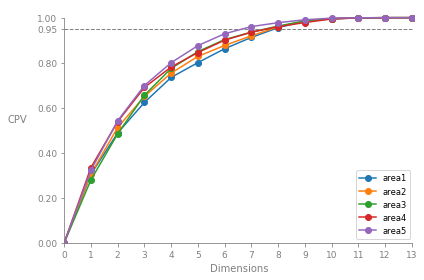

In [111]:
p = pca_expl_var_areas_df_cumulative_sum.iloc[:-1, :].plot(marker="o", alpha=1)
#plt.axhline(0.95, c="k", alpha=0.5)

plt.xlabel("Dimensions", c='grey')
plt.ylabel(r"CPV", c='grey', rotation=0, labelpad=20)
plt.ylim((0, 1.05))

# Change display of spines
p.spines['right'].set_visible(False)
p.spines['top'].set_visible(False)

# Set the color of the visible spines
p.spines['left'].set_color('grey')
p.spines['bottom'].set_color('grey')

# Set the bounds of the spines
p.set_xlim(0, n_columns-0.9)
p.set_ylim(0, 1.05)

# Set axes ticks
p.set_xticks([x for x in range(n_columns)])
p.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0])

p.spines['bottom'].set_bounds(0.0, n_columns-1)
p.spines['left'].set_bounds(0.0, 1.0)

# Set general tick parameters
p.tick_params(axis='both',
              direction='out',
              colors='grey',
              labelsize=9)

plt.hlines(0.95, 0, n_columns-1, color='grey', linewidth=1, linestyle="--")

plt.gcf().set_facecolor('white')

# plt.margins(1)
plt.tight_layout()

plt.legend(loc="lower right", frameon=True, fontsize='small')

plt.savefig("../_FIGURES/cpv/cpv_all_areas.pdf")
plt.show();

## Biplots

### remarks
1) when adjusting the scale for the form biplots (loading_factor=3), the axes will stay the same --> will give a distorted picture. However, without a scaling, de figure would be too small to see anything on it. 

2) covariance biplot the ray for the oth column is situated outside the graph, could also change the scale, but this will distort the picture 

3) when setting show_legend=False, legend still shows, but now even bigger, setting legend_outside_pool=True also doesn't seem to work.

4) point cloud of the covariance biplot very small, don't really directly know how to enlarge this

### General outline biplots

In [103]:
# Concatenate pc scores with metadata for plotting of biplot
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [104]:
color_dict_time = {
    "Tr": sns.color_palette()[0],
    "Tr-J": sns.color_palette()[1],
     "J": sns.color_palette()[2],
     "K": sns.color_palette()[3],
     "Pg": sns.color_palette()[4],
     "Mz": sns.color_palette()[5],
}

In [105]:
hue_order_time = ["Tr", "Tr-J", "J", "K", "Pg", "Mz"]

In [106]:
# Or even less chance of making an error
# Reuse the correct order we've already defined eralier on
hue_order_time = list(color_dict_time.keys())

In [107]:
mineralogy_all_areas[area].columns

Index(['SiO2', 'TiO2', 'Al2O3', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O',
       'K2O', 'P2O5', 'l.i.', 'oth', 'sum'],
      dtype='object')

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


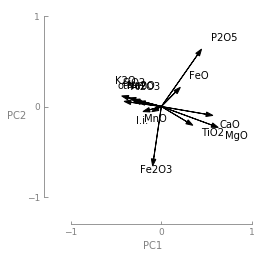

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


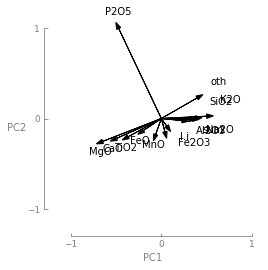

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


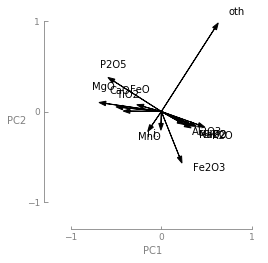

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


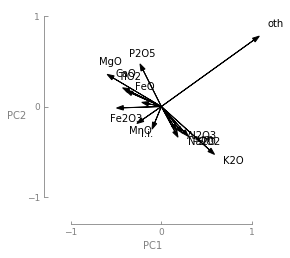

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


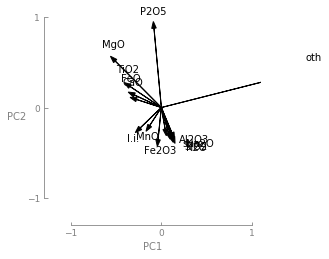

Wall time: 999 ms


In [135]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='covariance',
                 plot_scores=False,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=1,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue='time',
                 hue_order=hue_order_time,
                 palette=color_dict_time,
                 s=10)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


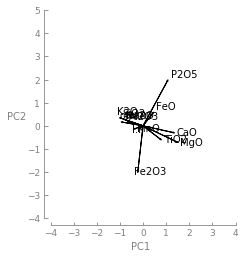

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


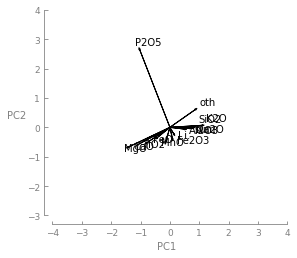

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


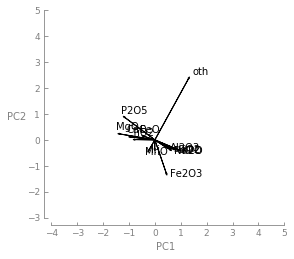

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


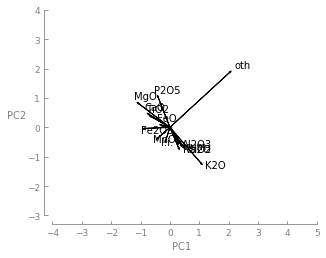

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


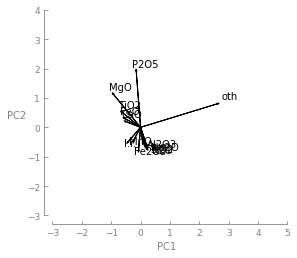

Wall time: 1.19 s


In [139]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='form',
                 plot_scores=False,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=3,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="time",
                 hue_order=hue_order_time,
                 palette=color_dict_time,
                 s=10)

### Biplots QAPF

In [140]:
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [141]:
# Here's an example of how you can achieve the same cell outcome as the following 5-6 cells by using a for loop
for area, data in mineralogy_pca_metadata_all_areas.items():
    print(f"{area} - QAPF value counts")
    data["QAPF"].value_counts()
    print("\n")

area1 - QAPF value counts


area2 - QAPF value counts


area3 - QAPF value counts


area4 - QAPF value counts


area5 - QAPF value counts




In [142]:
metadata_area1["QAPF"].value_counts()

monzo granite                             1144
quartz monzonite                           119
granodiorite                               112
quartz monzodiorite\quartz monzogabbro      62
syeno granite                               14
monzodiorite monzogabbro                     5
monzonite                                    2
quartz-rich granitoid                        1
Name: QAPF, dtype: int64

In [143]:
metadata_area2["QAPF"].value_counts()

monzo granite                                      690
granodiorite                                       186
quartz monzodiorite\quartz monzogabbro              94
quartz monzonite                                    48
monzodiorite monzogabbro                             9
syeno granite                                        8
monzonite                                            2
quartz diorite\quartz gabbro\quartz anorthosite      1
tonalite                                             1
Name: QAPF, dtype: int64

In [144]:
metadata_area3["QAPF"].value_counts()

monzo granite                                      751
granodiorite                                       178
quartz monzodiorite\quartz monzogabbro             103
quartz monzonite                                    61
monzodiorite monzogabbro                             7
syeno granite                                        4
tonalite                                             2
quartz-rich granitoid                                2
quartz diorite\quartz gabbro\quartz anorthosite      1
monzonite                                            1
Name: QAPF, dtype: int64

In [145]:
metadata_area4["QAPF"].value_counts()

monzo granite                                      239
granodiorite                                       128
quartz monzodiorite\quartz monzogabbro              53
quartz monzonite                                    23
tonalite                                             9
monzodiorite monzogabbro                             6
syeno granite                                        5
quartz diorite\quartz gabbro\quartz anorthosite      2
diorite gabbro anorthosite                           1
Name: QAPF, dtype: int64

In [146]:
metadata_area5["QAPF"].value_counts()

monzo granite                             144
granodiorite                               11
quartz monzodiorite\quartz monzogabbro     10
quartz monzonite                           10
monzonite                                   2
monzodiorite monzogabbro                    2
Name: QAPF, dtype: int64

____

**You can remove this section between the lines without affecting the rest of the code**

In [147]:
qapf.QAPF_upper_regions_numbers

{nan: 0,
 'quartzolite': 1,
 'quartz-rich granitoid': 2,
 'alkali feldspar granite': 3,
 'syeno granite': 4,
 'monzo granite': 5,
 'granodiorite': 6,
 'tonalite': 7,
 'quartz alkali\nfeldspar syenite': 8,
 'quartz syenite': 9,
 'quartz monzonite': 10,
 'quartz monzodiorite\nquartz monzogabbro': 11,
 'quartz diorite\nquartz gabbro\nquartz anorthosite': 12,
 'alkali feldspar syenite': 13,
 'syenite': 14,
 'monzonite': 15,
 'monzodiorite monzogabbro': 16,
 'diorite gabbro anorthosite': 17}

In [148]:
plots.QAPF_upper_regions_numbers_vs_cmap

{0: 0.0,
 1: 0.05,
 2: 0.1,
 3: 0.15000000000000002,
 4: 0.2,
 5: 0.25,
 6: 0.30000000000000004,
 7: 0.35000000000000003,
 8: 0.4,
 9: 0.45,
 10: 0.5,
 11: 0.55,
 12: 0.6000000000000001,
 13: 0.65,
 14: 0.7000000000000001,
 15: 0.75,
 16: 0.8,
 17: 0.8500000000000001,
 18: 0.9,
 19: 0.9500000000000001,
 20: 1.0}

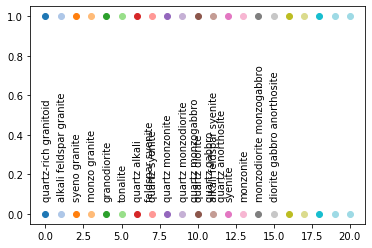

In [149]:
# This was jst a quick visual check for me
for key, value in plots.QAPF_upper_regions_numbers_vs_cmap.items():
    plt.plot(key, 0, color=cm.tab20(value), marker='o')
    try:
        plt.text(key-0.25, 0.075, plots.QAPF_upper_regions_numbers_inverse[key+2], rotation=90)
    except KeyError as error:
        pass
    plt.plot(key, 1, color=cm.tab20(key), marker='o')
plt.show();

___

In [150]:
# Create universal color map
# Same coloring scheme as we used in our research paper
# You can use a different one if you like but this way it's easier for me to recognize the classes :)
color_dict_QAPF = {}

for key, value in zip(list(qapf.QAPF_upper_regions_numbers.keys())[1:], range(20)):        
    color_dict_QAPF[key.replace("\n", "\\")] = cm.tab20(value-1)

In [151]:
color_dict_QAPF

{'quartzolite': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'quartz-rich granitoid': (0.12156862745098039,
  0.4666666666666667,
  0.7058823529411765,
  1.0),
 'alkali feldspar granite': (0.6823529411764706,
  0.7803921568627451,
  0.9098039215686274,
  1.0),
 'syeno granite': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'monzo granite': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 'granodiorite': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'tonalite': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 'quartz alkali\\feldspar syenite': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392,
  1.0),
 'quartz syenite': (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 'quartz monzonite': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353,
  1.0),
 'quartz monzodiorite\\quartz monzogabbro': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589,
  1.0),
 'qua

In [152]:
# This order is conform the QAPF diagram order
hue_order_QAPF = list(color_dict_QAPF.keys())
hue_order_QAPF

['quartzolite',
 'quartz-rich granitoid',
 'alkali feldspar granite',
 'syeno granite',
 'monzo granite',
 'granodiorite',
 'tonalite',
 'quartz alkali\\feldspar syenite',
 'quartz syenite',
 'quartz monzonite',
 'quartz monzodiorite\\quartz monzogabbro',
 'quartz diorite\\quartz gabbro\\quartz anorthosite',
 'alkali feldspar syenite',
 'syenite',
 'monzonite',
 'monzodiorite monzogabbro',
 'diorite gabbro anorthosite']

**Added the option of plotting the legend outside of the plot.**  
**As a tip, once I want to make my final figures, I usually import figures into Inkscape, make a general legend and show this once instead of giving every figure its own legend.**  
**Alternatevly, I could also pass you on the QAPF diagram legend I used in the QAPF map overview figure from the paper if you would like to use that in your thesis.**

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


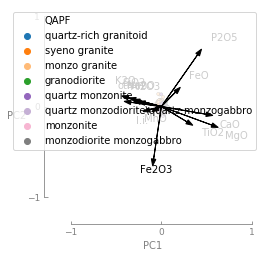

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


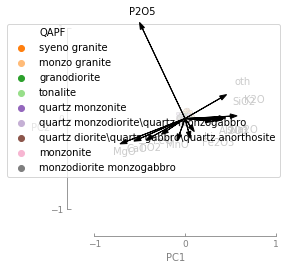

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


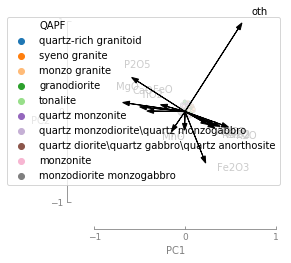

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


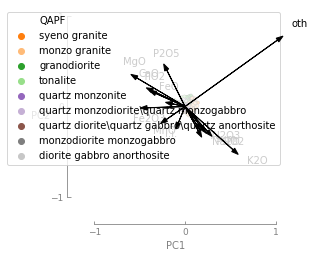

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


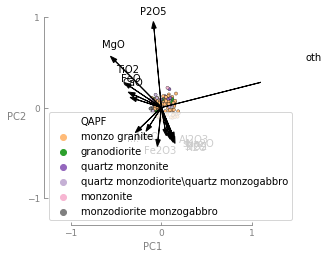

Wall time: 2.75 s


In [159]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='covariance',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 show_legend=False,
                 legend_outside_pool=True,
                 show_labels=True,
                 loading_factor=1,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="QAPF",
                 hue_order=hue_order_QAPF,
                 palette=color_dict_QAPF,
                 s=10)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


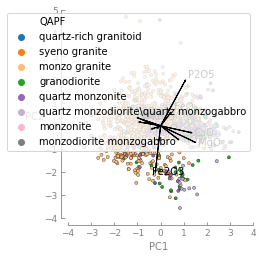

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


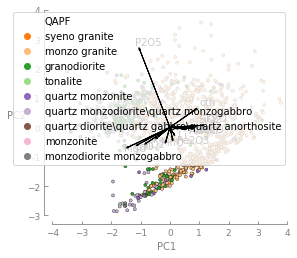

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


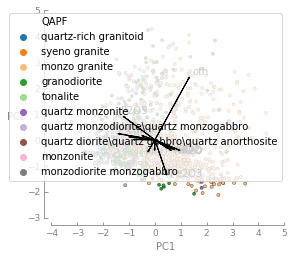

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


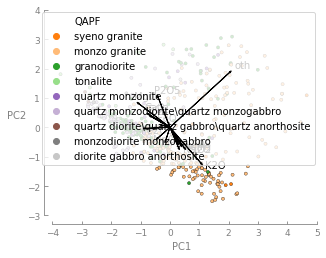

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


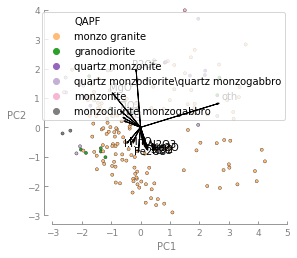

Wall time: 3.02 s


In [166]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='form',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 show_legend=False,
                 legend_outside_pool=True,
                 loading_factor=3,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="QAPF",
                 hue_order=hue_order_QAPF,
                 palette=color_dict_QAPF,
                 s=10)

### Biplots highlighting datapoints where zero's were replaced

In [223]:
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [224]:
# You could do the following cells again with a for loop

In [225]:
metadata_area1["zero"].value_counts()

oth           1210
mineraloth     167
no_zero         61
mineral         21
Name: zero, dtype: int64

In [226]:
metadata_area2["zero"].value_counts()

oth           615
mineraloth    287
no_zero       115
mineral        22
Name: zero, dtype: int64

In [227]:
metadata_area3["zero"].value_counts()

oth           633
no_zero       266
mineraloth    167
mineral        44
Name: zero, dtype: int64

In [228]:
metadata_area4["zero"].value_counts()

oth           258
no_zero       137
mineraloth     46
mineral        25
Name: zero, dtype: int64

In [229]:
metadata_area5["zero"].value_counts()

oth           69
no_zero       51
mineraloth    43
mineral       16
Name: zero, dtype: int64

In [230]:
metadata["zero"].value_counts()

oth           69
no_zero       51
mineraloth    43
mineral       16
Name: zero, dtype: int64

In [231]:
color_dict_zeros = {
    "oth": sns.color_palette()[0],
     "no_zero": sns.color_palette()[1],
     "mineraloth": sns.color_palette()[2],
     "mineral": sns.color_palette()[3],
}

In [232]:
hue_order_zeros = ["oth", "no_zero", "mineraloth", "mineral"]

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


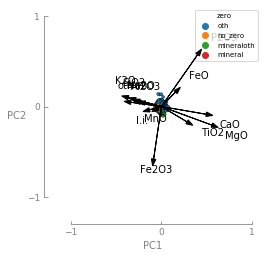

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


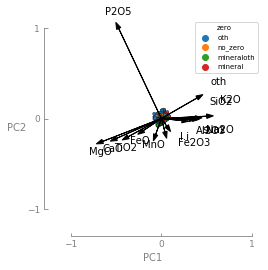

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


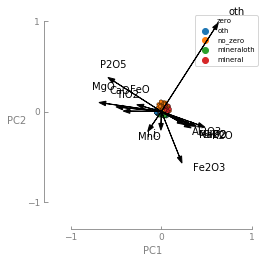

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


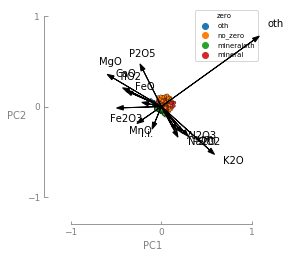

[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


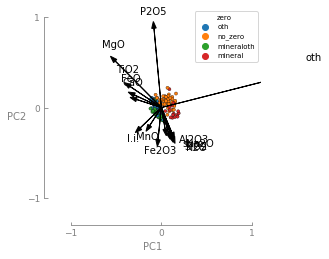

Wall time: 2.11 s


In [233]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='covariance',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=1,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="zero",
                 hue_order=hue_order_zeros,
                 palette=color_dict_zeros,
                 s=10)

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


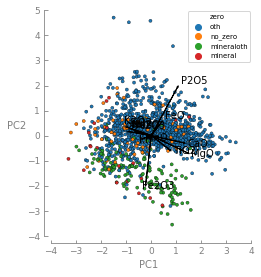

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


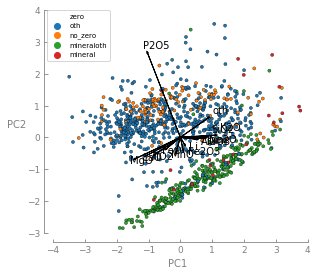

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


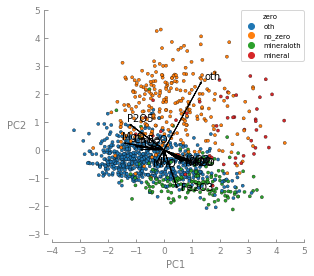

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


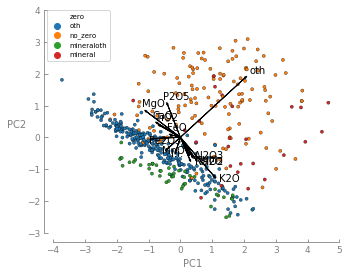

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


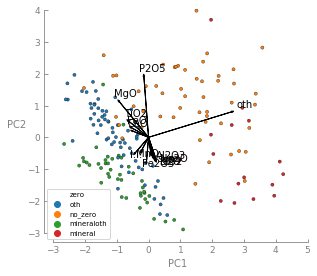

Wall time: 2.3 s


In [234]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='form',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=3,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="zero",
                 hue_order=hue_order_zeros,
                 palette=color_dict_zeros,
                 s=10)

### Biplots organizing l.i.; others, and P2O5 together

In [112]:
# Concatenate pc scores with metadata for plotting of biplot
mineralogy_pca_metadata_all_areas = {}

for area, metadata in metadata_all_areas.items():
    mineralogy_pca_metadata_all_areas[area] = pd.concat([mineralogy_pca_df_all_areas[area], metadata], axis=1)

In [113]:
color_dict_time = {
    "Tr": sns.color_palette()[0],
    "Tr-J": sns.color_palette()[1],
     "J": sns.color_palette()[2],
     "K": sns.color_palette()[3],
     "Pg": sns.color_palette()[4],
     "Mz": sns.color_palette()[5],
}

In [114]:
hue_order_time = ["Tr", "Tr-J", "J", "K", "Pg", "Mz"]

In [115]:
# Or even less chance of making an error
# Reuse the correct order we've already defined eralier on
hue_order_time = list(color_dict_time.keys())

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


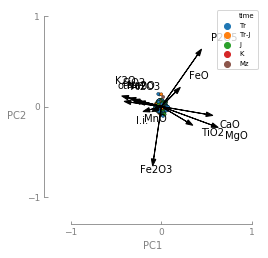

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


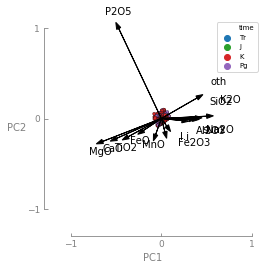

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


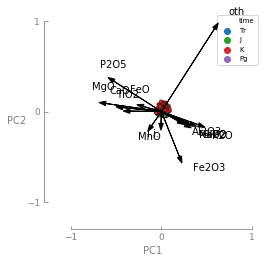

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


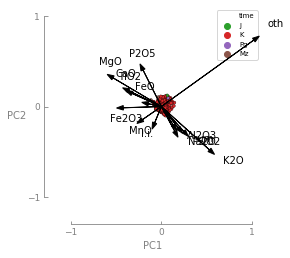

C:\Users\Sebastian\Desktop\python_map\New\Vistelius_1995_OCR\_ANALYSIS\plots\plots.py:1335: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[-1.0, 0.0, 1.0]
[-1.0, 0.0, 1.0]


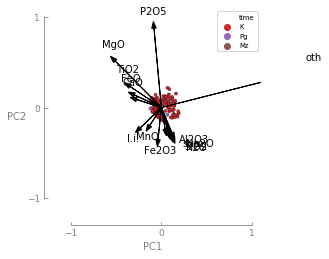

Wall time: 2.37 s


In [170]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='covariance',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=1,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="time",
                 hue_order=hue_order_time,
                 palette=color_dict_time,
                 s=10)

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


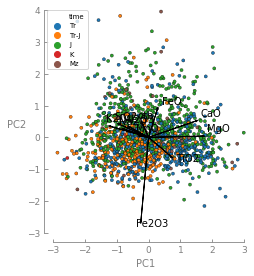

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


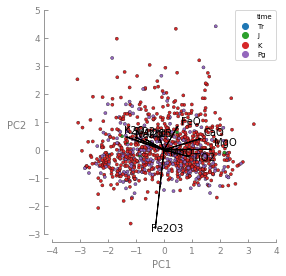

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]


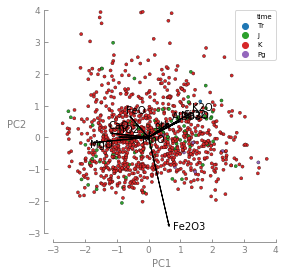

[-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]


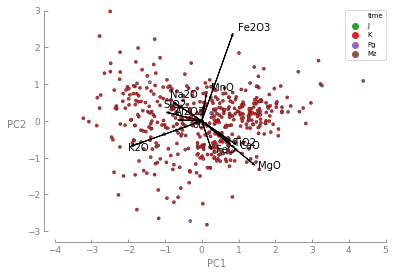

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0]
[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


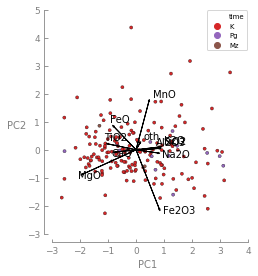

Wall time: 2.62 s


In [171]:
%%time
for area, pca in mineralogy_pca_all_areas.items():
    plots.biplot(pca, 
                 mineralogy_pca_metadata_all_areas[area], 
                 columns=mineralogy_all_areas[area].columns, 
                 biplot_type='form',
                 plot_scores=True,
                 arrow_width=0.001,
                 arrow_head_width=0.05,
                 group=area,
                 plot_datalabels=False,
                 adjust='box',
                 xspacing=1,
                 yspacing=1,
                 xformat="2.0f",
                 yformat="2.0f",
                 axes_offset=0.3,
                 loading_factor=3,
                 loadings_forward=True,
                 loading_label_offsets=(0.15, 0.15),
                 extra_ticks=[[], [], [], []],
                 hue="time",
                 hue_order=hue_order_time,
                 palette=color_dict_time,
                 s=10)

## Saving of data

In [400]:
# Save data as pickle files to use them in later notebooks
preproc.save_obj(mineralogy_area1, "mineralogy_area1") # mineralogy
preproc.save_obj(mineralogy_clr_area1, "mineralogy_clr_area1") # mineralogy clr
preproc.save_obj(mineralogy_pca_area1, "mineralogy_pca_area1") # mineralogy pca info
preproc.save_obj(mineralogy_pca_area1_df, "mineralogy_pca_area1_df") # mineralogy pca scores

preproc.save_obj(coordinates_area1, "coordinates_area1") # coordinates latlon
preproc.save_obj(coordinates_utm_area1, "coordinates_utm_area1") # coordinates utm
preproc.save_obj(metadata_area1, "metadata_area1") # metadata

____

In [401]:
coordinates_utm_area1

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
2,1.436111e+06,6.102354e+06,48,U
6,1.113927e+06,5.652652e+06,48,U
9,1.068636e+06,5.598845e+06,48,U
10,1.098840e+06,5.690263e+06,48,U
11,9.048985e+05,5.630297e+06,48,U
...,...,...,...,...
4538,1.304961e+06,5.902228e+06,48,U
4552,1.328849e+06,6.028456e+06,48,U
4574,1.413275e+06,6.019949e+06,48,U
4585,1.455811e+06,5.990438e+06,48,U
